In [1]:
!nvidia-smi

Sat Mar 14 19:14:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install gdown

In [3]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 46.4MB/s 
     |████████████████████████████████| 3.9MB 65.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [4]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
!gdown --id 1e3xCn_BB55nIzzsWjb0doVtwbgP_LThn --output test.csv

/tensorflow-2.1.0/python3.6/pkg_resources/py2_warn.py:22: UserWarning: Setuptools will stop working on Python 2
************************************************************
You are running Setuptools on Python 2, which is no longer
supported and
>>> SETUPTOOLS WILL STOP WORKING <<<
in a subsequent release (no sooner than 2020-04-20).
Please ensure you are installing
Setuptools using pip 9.x or later or pin to `setuptools<45`
in your environment.
If you have done those things and are still encountering
this message, please comment in
https://github.com/pypa/setuptools/issues/1458
about the steps that led to this unsupported combination.
************************************************************
  sys.version_info < (3,) and warnings.warn(pre + "*" * 60 + msg + "*" * 60)
Downloading...
From: https://drive.google.com/uc?id=1e3xCn_BB55nIzzsWjb0doVtwbgP_LThn
To: /content/test.csv
12.0MB [00:00, 38.1MB/s]


In [0]:
import csv

In [72]:
df = pd.read_csv('test.csv', delimiter=";", error_bad_lines=False, date_parser=lambda x: pd.to_datetime(x, format='%m/%d/%Y %I:%M:%S %p'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
df.head()

,TimeStamp,userID,bytesSent,bytesReceived,bytesReceivedProxy,hostFull,isHTTPS,CL_RTT,OS_RTT,CL_Retrans,OS_Retrans,OS_Transmit_time_noSubstract,CL_Transmit_time_noSubstract,OS_Transmit_time,CL_Transmit_time
0,1.536103e+12,2b0915bd4dfdc934be2dfb405ae96bba,1672,4340,4340,cf6faa330784a80dae3a790faaa28070.1d5920f4b44b2...,True,46,5,0,0,220.0,220.0,0.06,0.22
1,1.536103e+12,e275e527dc681fae874e6c3e76383788,941,682,682,523af537946b79c4f8369ed39ba78605.71c4e7ccdfe65...,True,349,9,3,0,73850.0,73850.0,0.03,600.09
2,1.536103e+12,40428fcecda8e8018af8561f59faeefb,1326,355,355,64a703a0def5637248bed648e5e61277.971f79dc187e6...,True,47,179,0,0,260.0,260.0,0.05,-2.05
3,1.536103e+12,97add46e757d2b240926e869a668e128,791,229,229,2db4e283785f1b197b80bd57295533a3.05d986b30d7eb...,True,73,1,0,0,180.0,180.0,-0.09,-0.09
4,1.536103e+12,4db5f34110e374a4a2a242f5b015cc03,3239,5605,5605,4eae35f1b35977a00ebd8086c259d4c9.e10f949fcaacd...,True,55,4,0,0,1840.0,1840.0,0.04,Apr.63


In [74]:
train_size = int(len(df) * 0.85)
test_size = len(df) - train_size
train, test = df.iloc[3:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(59685, 15) (10534, 15)


In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['OS_RTT']])

train['OS_RTT'] = scaler.transform(train[['OS_RTT']])
test['OS_RTT'] = scaler.transform(test[['OS_RTT']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [77]:
TIME_STEPS = 3

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['OS_RTT']], train.OS_RTT, TIME_STEPS)
X_test, y_test = create_dataset(test[['OS_RTT']], test.OS_RTT, TIME_STEPS)

print(X_train.shape)

(59682, 3, 1)


In [0]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [79]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Train on 47745 samples, validate on 11937 samples
Epoch 1/10
47745/47745 [==============================] - 11s 230us/sample - loss: 0.3738 - val_loss: 0.3879
Epoch 2/10
47745/47745 [==============================] - 8s 178us/sample - loss: 0.3702 - val_loss: 0.3877
Epoch 3/10
47745/47745 [==============================] - 8s 177us/sample - loss: 0.3700 - val_loss: 0.3878
Epoch 4/10
47745/47745 [==============================] - 9s 179us/sample - loss: 0.3699 - val_loss: 0.3878
Epoch 5/10
47745/47745 [==============================] - 9s 180us/sample - loss: 0.3697 - val_loss: 0.3878
Epoch 6/10
47745/47745 [==============================] - 8s 176us/sample - loss: 0.3696 - val_loss: 0.3878
Epoch 7/10
47745/47745 [==============================] - 8s 176us/sample - loss: 0.3696 - val_loss: 0.3878
Epoch 8/10
47745/47745 [==============================] - 9s 181us/sample - loss: 0.3696 - val_loss: 0.3877
Epoch 9/10
47745/47745 [==============================] - 9s 184us/sample - loss: 0.3

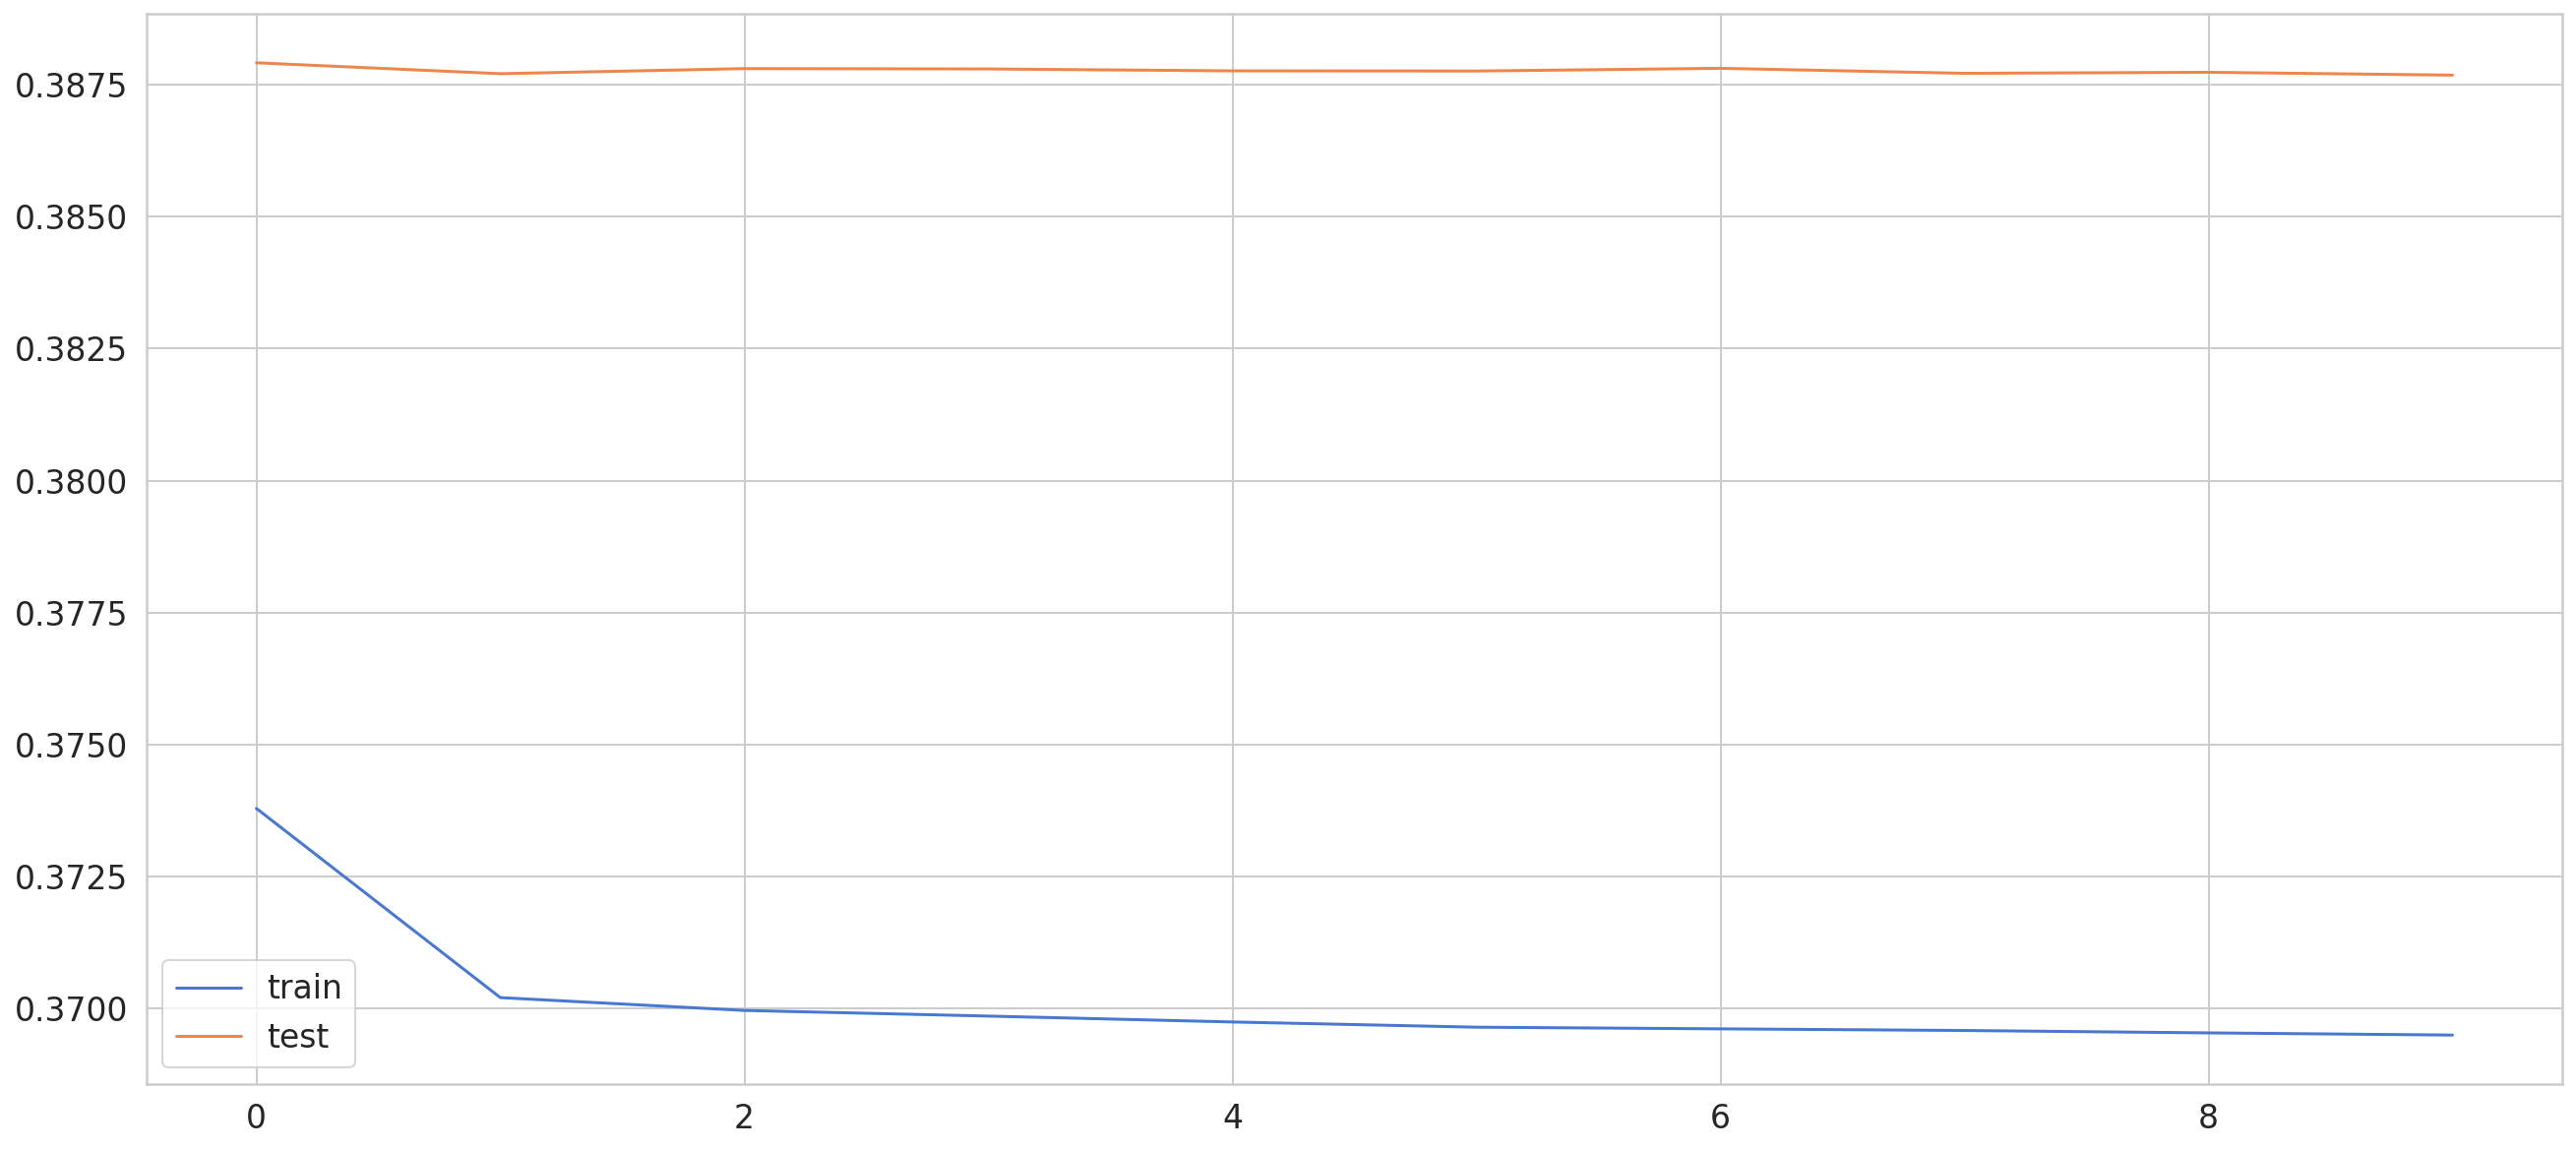

In [80]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [0]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

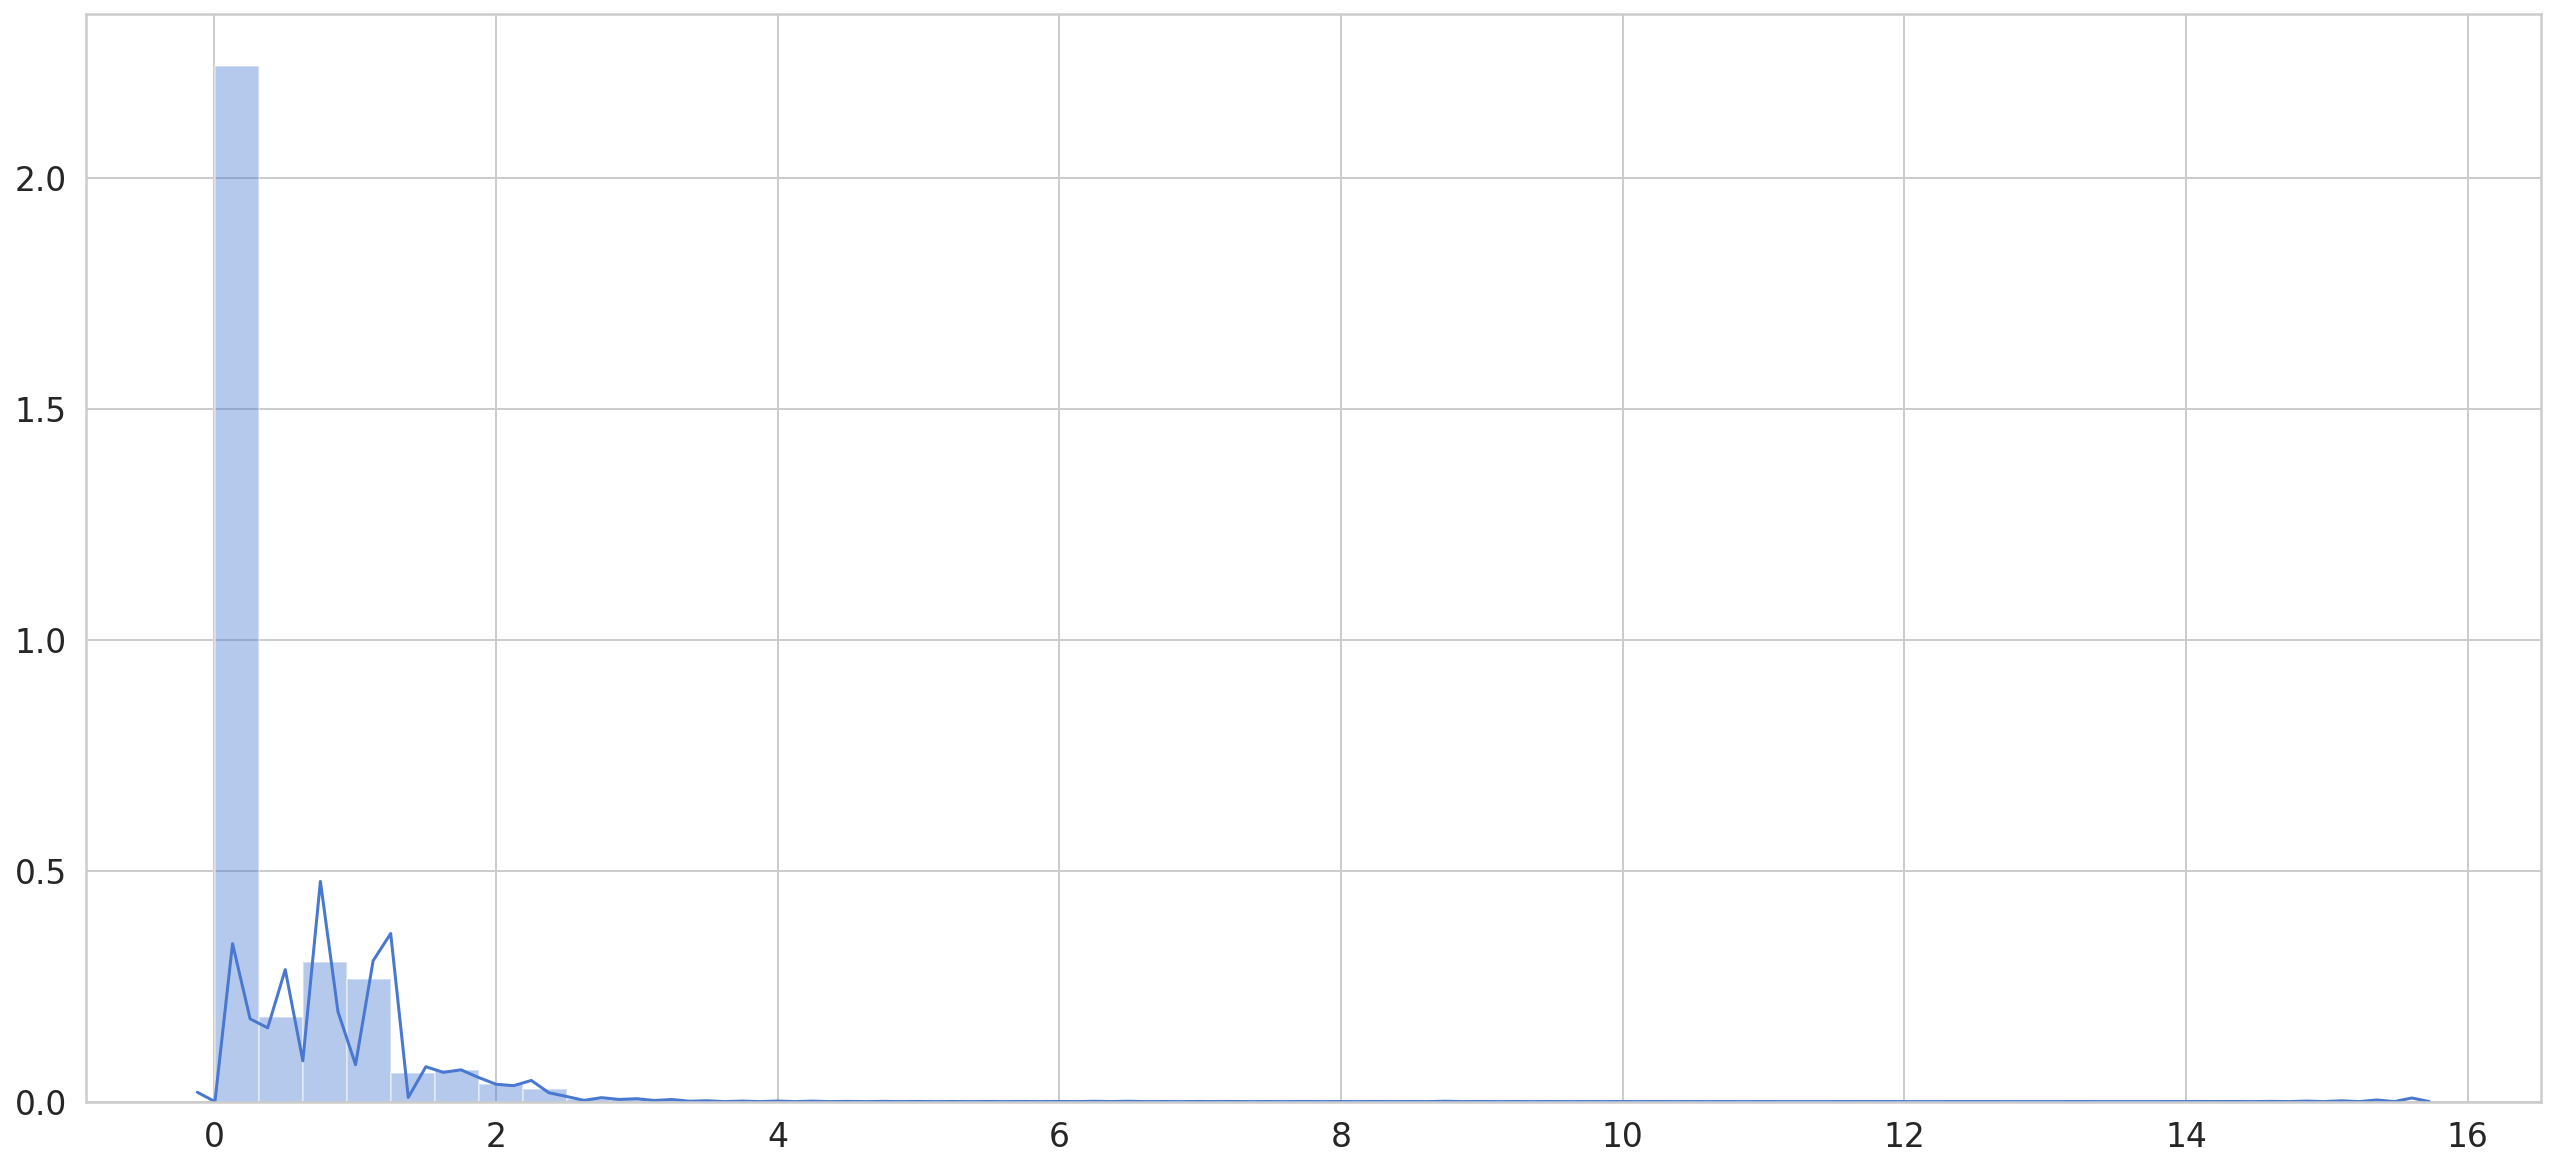

In [82]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [0]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [0]:
THRESHOLD = 2.5

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['OS_RTT'] = test[TIME_STEPS:].OS_RTT

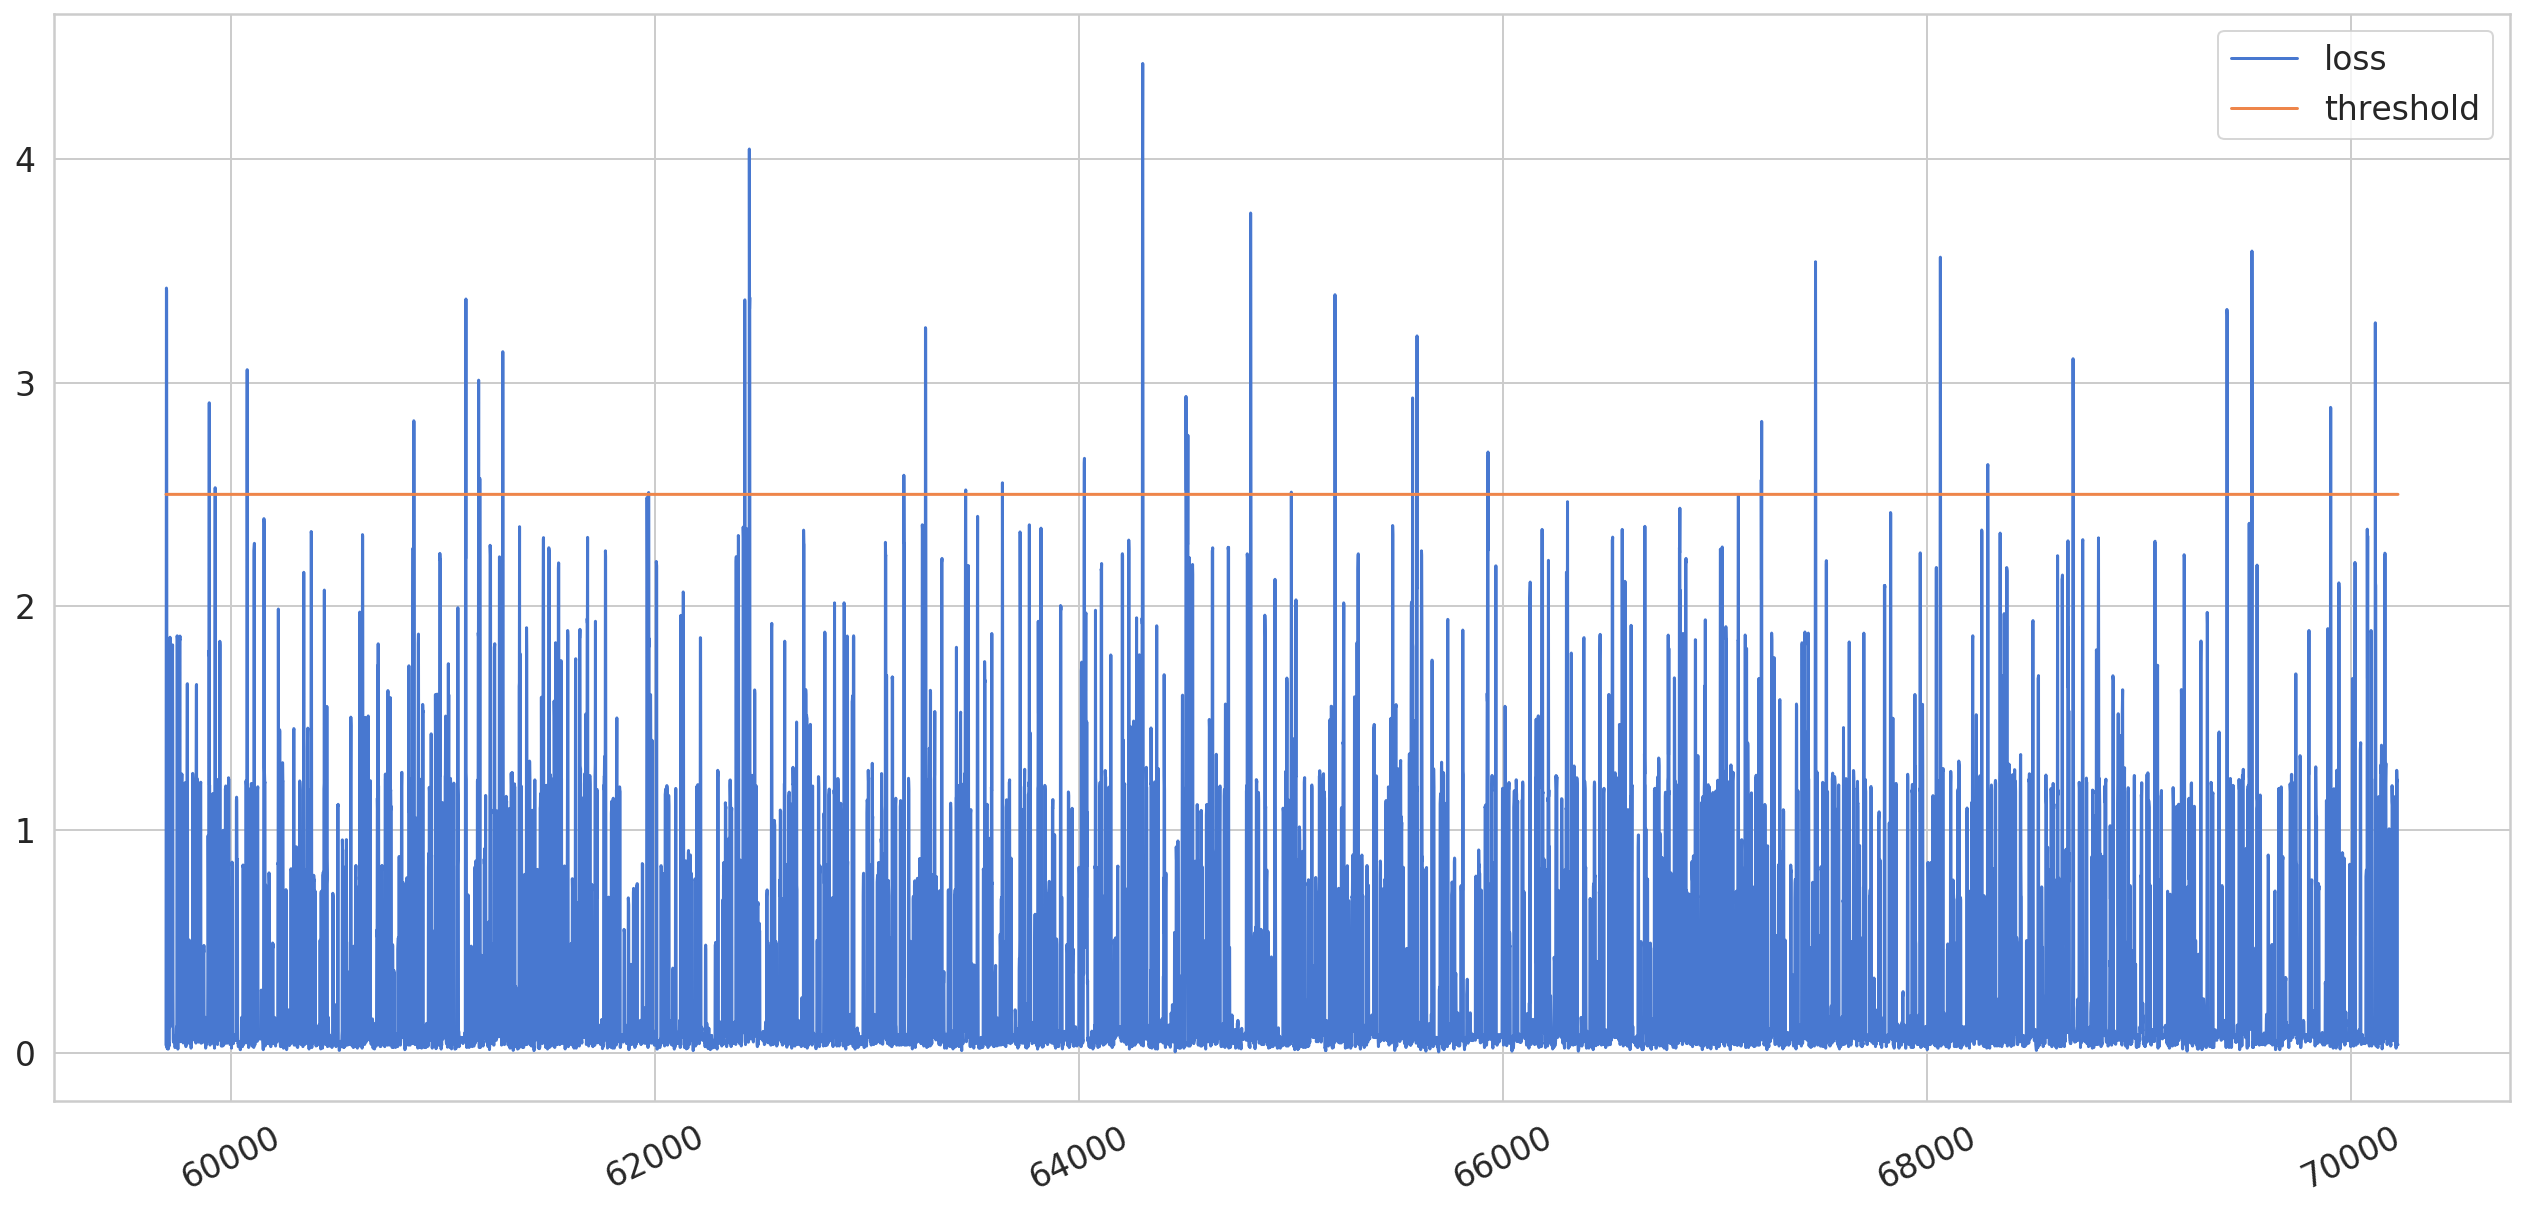

In [85]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [87]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,OS_RTT
59693,3.422976,2.5,True,-0.344641
59694,3.411648,2.5,True,-0.344641
59895,2.909773,2.5,True,-0.406058
59923,2.529737,2.5,True,-0.365113
60073,2.638748,2.5,True,1.027000


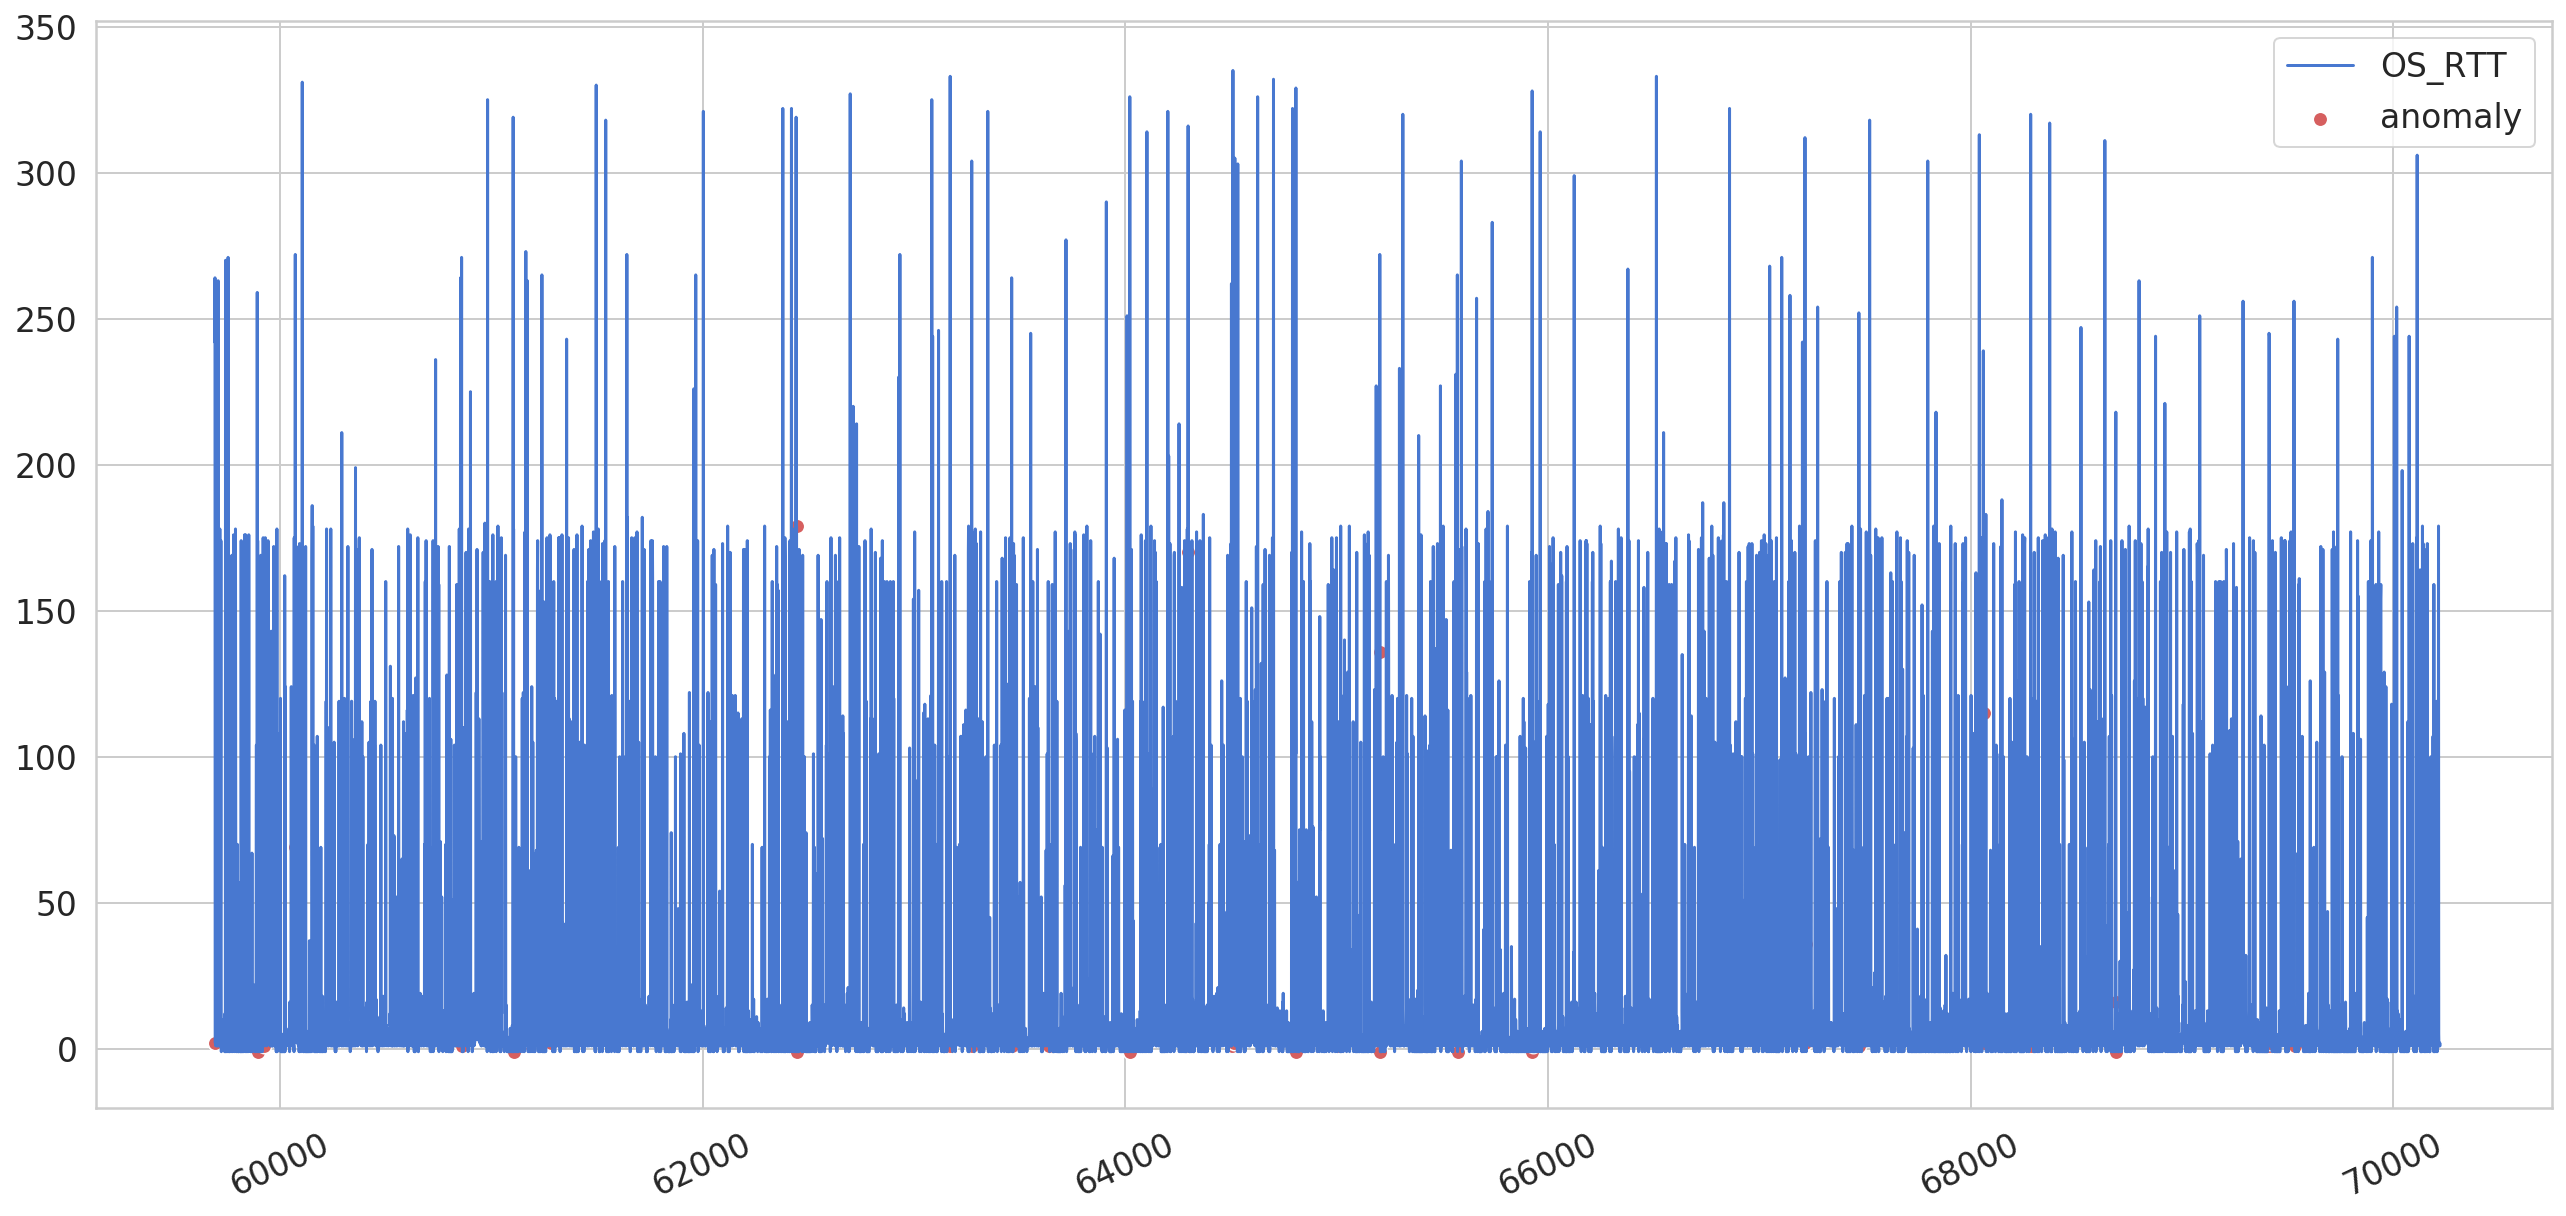

In [88]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].OS_RTT), 
  label='OS_RTT'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.OS_RTT),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();